<a href="https://colab.research.google.com/github/alinorouziani/TransferLearningPytorchEfficientnet/blob/main/TransferLearningPytorchEfficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms, datasets

try:
  from torchinfo import summary
except:
  print("Couldn't find the file. Installing it...")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from PytorchModular import SetupData, Training
except:
  print("Couldn't find the file. Installing it...")
  !git clone https://github.com/alinorouziani/PytorchModular
  !mv PytorchModular
  from PytorchModular import SetupData, Training
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [24]:
import os
import requests
import zipfile
from pathlib import Path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
if image_path.is_dir():
  print(f"{image_path} already exists.")
else:
  image_path.mkdir(parents=True, exist_ok=True)
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  zip_ref.extractall(image_path)
os.remove(data_path / "pizza_steak_sushi.zip")

train_dir = image_path / "train"
test_dir = image_path / "test"

data/pizza_steak_sushi already exists.


In [25]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
auto_transforms = weights.transforms()
train_dataloader, test_dataloader, class_names = SetupData.create_dataloaders(train_dir, test_dir, auto_transforms, 32)
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [26]:
summary(model=model,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [27]:
for param in model.features.parameters():
  param.requires_grad = False
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device)

In [28]:
summary(model=model,
        input_size = (1, 3, 224, 224),
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [29]:
from timeit import default_timer as timer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
start_timer = timer()
results = Training.train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer = optimizer,
               loss_fn = loss_fn,
               epochs = 4,
               device=device)
end_timer = timer()
print(f"Total training time: {end_timer - start_timer:.3f} seconds")

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.09 | train_acc: 0.43 | test_loss: 0.84 | test_acc: 0.78
Epoch: 2 | train_loss: 0.85 | train_acc: 0.69 | test_loss: 0.80 | test_acc: 0.74
Epoch: 3 | train_loss: 0.82 | train_acc: 0.69 | test_loss: 0.74 | test_acc: 0.76
Epoch: 4 | train_loss: 0.72 | train_acc: 0.74 | test_loss: 0.61 | test_acc: 0.82
Total training time: 10.397 seconds


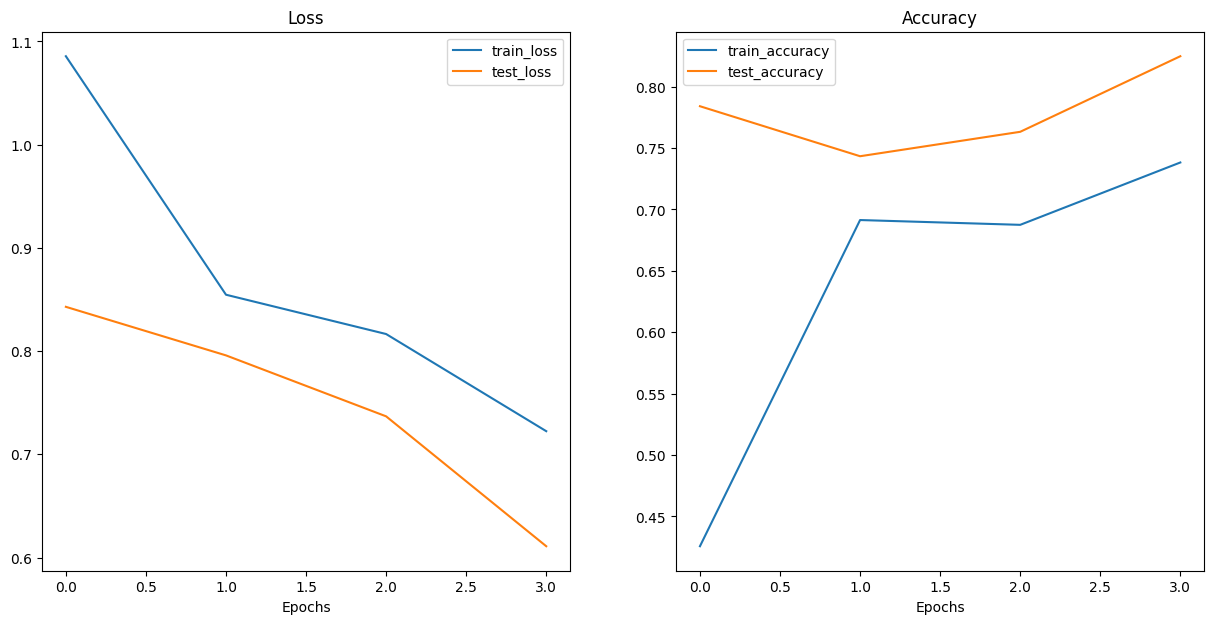

In [31]:
def plot_loss_curves(results):
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]
  epochs = range(len(results["train_loss"]))
  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

plot_loss_curves(results)

In [42]:
from typing import List, Tuple
from PIL import Image
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  img = Image.open(image_path)
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])
    model.to(device)
    model.eval()
    with torch.inference_mode():
      transformed_image = image_transform(img).unsqueeze(dim=0)
      target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

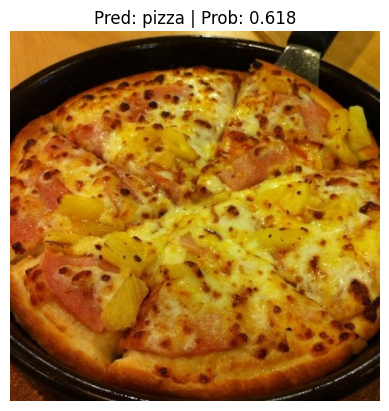

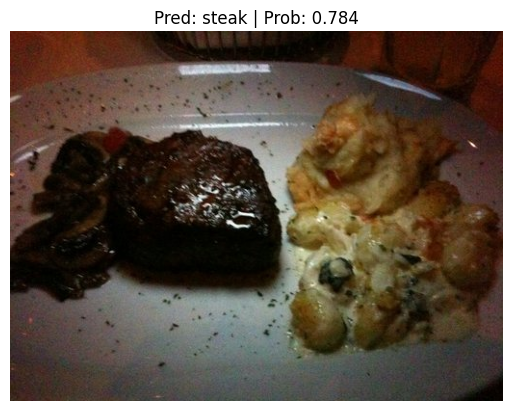

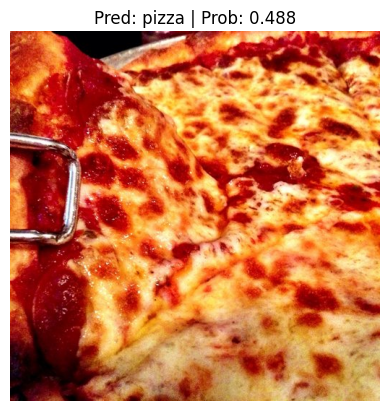

In [46]:
import random
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, 3)
for image_path in test_image_path_sample:
  pred_and_plot_image(model, image_path, class_names)